In [47]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaConfig, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import load_dataset
from scipy.special import softmax
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [39]:
dataset = load_dataset("katielink/moleculenet-benchmark", "hiv")
dataset = dataset.remove_columns(["activity"])
dataset =  dataset.rename_columns({"smiles": "text", "HIV_active": "label"})


In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32900
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4113
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 4113
    })
})

In [41]:
pretrained_tokenizer = RobertaTokenizerFast.from_pretrained("seyonec/PubChem10M_SMILES_BPE_60k")
model = RobertaForSequenceClassification(RobertaConfig(num_labels = 2))

tokenizer = pretrained_tokenizer.train_new_from_iterator(dataset, vocab_size=50265)

tokenizer = pretrained_tokenizer
# model = RobertaForSequenceClassification.from_pretrained("roberta-base").to("cpu")

test_mol = "C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3)CC(c3ccccc3)=[O+]2)[O+]=C(c2ccccc2)C1"
print(tokenizer.tokenize(test_mol), "\n\n", pretrained_tokenizer.tokenize(test_mol))

def preprocess_function(examples):
    return tokenizer(examples["text"], max_length=512, truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)




['C', '(=', 'Cc', '1', 'ccccc', '1', ')', 'C', '1', '=[', 'O', '+][', 'Cu', '-', '3', ']', '2', '([', 'O', '+]=', 'C', '(', 'C', '=', 'Cc', '3', 'ccccc', '3', ')', 'CC', '(', 'c', '3', 'ccccc', '3', ')=[', 'O', '+]', '2', ')[', 'O', '+]=', 'C', '(', 'c', '2', 'ccccc', '2', ')', 'C', '1'] 

 ['C', '(=', 'Cc', '1', 'ccccc', '1', ')', 'C', '1', '=[', 'O', '+][', 'Cu', '-', '3', ']', '2', '([', 'O', '+]=', 'C', '(', 'C', '=', 'Cc', '3', 'ccccc', '3', ')', 'CC', '(', 'c', '3', 'ccccc', '3', ')=[', 'O', '+]', '2', ')[', 'O', '+]=', 'C', '(', 'c', '2', 'ccccc', '2', ')', 'C', '1']


In [42]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    pred_scores = softmax(predictions, axis=-1)[:, 1]
    auc = evaluate.load("roc_auc")
    return auc.compute(prediction_scores=pred_scores, references=labels)

In [43]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/ubuntu/miniconda3/envs/generic/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/ubuntu/miniconda3/envs/generic/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.140990,0.671117
2,0.146700,0.135738,0.690939
3,0.132400,0.133305,0.702394
4,0.132400,0.136939,0.711280
5,0.126600,0.132722,0.718885


/home/ubuntu/miniconda3/envs/generic/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/miniconda3/envs/generic/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/miniconda3/envs/generic/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/miniconda3/envs/generic/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68

TrainOutput(global_step=1715, training_loss=0.13331709547571122, metrics={'train_runtime': 729.6507, 'train_samples_per_second': 225.45, 'train_steps_per_second': 2.35, 'total_flos': 9806371033220160.0, 'train_loss': 0.13331709547571122, 'epoch': 5.0})

In [46]:
preds, labels, metrics = trainer.predict(tokenized_dataset["test"])
pred_scores = softmax(preds, axis=-1)[:, 1]
auc = evaluate.load("roc_auc")
print(auc.compute(prediction_scores=pred_scores, references=labels))

/home/ubuntu/miniconda3/envs/generic/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'roc_auc': 0.699433500296052}


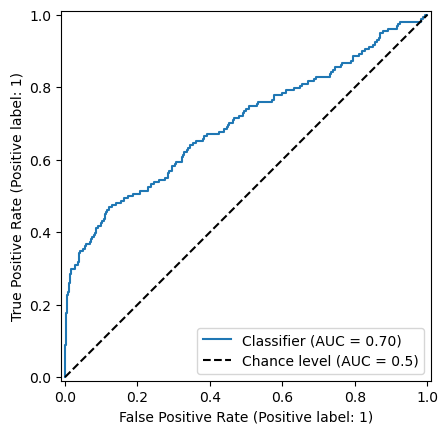

In [48]:
display = RocCurveDisplay.from_predictions(labels, pred_scores, plot_chance_level=True)